# 导入模型

In [1]:
import torch
import torch.nn as nn
# 定义一个从股票历史数据中提取风险因子的神经网络模型
class TtRiskFactor(nn.Module):
    def __init__(self,
                 features_size,
                 hidden_size,
                 risk_factor_size,
                 num_layers,
                 stock_size):
        super().__init__()
        self.features_size = features_size  # 特征尺寸
        self.hidden_size = hidden_size  # 隐藏层尺寸
        self.risk_factor_size = risk_factor_size  # 风险因子尺寸
        self.num_layers = num_layers  # GRU层数
        self.stock_size = stock_size  # 股票数量
        # 定义GRU层
        self.gru = nn.GRU(input_size=features_size,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)
        # 定义全连接层
        self.FC = nn.Linear(in_features=hidden_size * num_layers,
                            out_features=risk_factor_size)
        # 定义批量归一化层
        self.norm = nn.BatchNorm1d(num_features=stock_size)
    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        input_tensor = input_tensor
        period_size = input_tensor.shape[1]  # 获取输入张量的时间步长
        # 转换输入张量的形状
        input_tensor_ = input_tensor.permute((0, 2, 1, 3)).contiguous().view(-1,
                                                                             period_size,
                                                                             self.features_size)
        input_tensor_ = input_tensor_
        # 通过GRU层处理数据
        _, hidden = self.gru(input_tensor_)
        # 转换隐藏层输出形状 
        hidden_ = self.FC(hidden.view(-1, self.stock_size, self.hidden_size*self.num_layers))
        # 进行批量归一化
        Tt_risk_factors = self.norm(hidden_)
        return Tt_risk_factors

In [2]:
import torch
import torch.nn as nn
from typing import Tuple
# 定义了一个图注意力网络（GAT）模型，用于生成风险因子，在其他文件中被引用
class GraphAttentionNetworks(nn.Module):
    def __init__(self,
                 features_size,
                 dropout):
        super().__init__()
        self.features_size = features_size  # 特征尺寸
        self.dropout = dropout  # dropout 概率
        # 定义线性投影层
        self.proj = nn.Linear(in_features=features_size,
                              out_features=features_size,
                              bias=False)
        # 定义Dropout层
        self.dropout = nn.Dropout(dropout)
        # 定义缩放因子
        self.scale = torch.sqrt(torch.Tensor([features_size]).to(device))
        # 定义LeakyReLU激活函数
        self.leakyRelu = nn.LeakyReLU()
    def forward(self,
                query: torch.Tensor,
                key: torch.Tensor,
                value: torch.Tensor,
                mask=None) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size, stock_size = query.shape[0], query.shape[2]  # 获取批量大小和股票数量
        # 线性投影操作
        Q, K, V = self.proj(query), self.proj(key), self.proj(value)
        # 计算注意力打分
        a = torch.matmul(Q, K.permute(0, 1, 3, 2))/self.scale  # 使用缩放点积模型
        if mask is not None:
            a = a.masked_fill(mask == 0, -1e10)  # 应用掩码
        # 计算注意力分布
        e = self.leakyRelu(a)
        attention_distribution = torch.softmax(e, dim=-1)
        # 计算输出
        output = self.leakyRelu(torch.matmul(self.dropout(attention_distribution), V))
        return output, attention_distribution

In [3]:
# 使用GAT和GRU这两种RNN来从股票的历史序列数据中生成风险因子，使用了Graph_Attention_Networks中定义的网络
class CStRiskFactor(nn.Module):
    def __init__(self,
                 features_size,
                 hidden_size,
                 risk_factor_size,
                 num_layers,
                 stock_size,
                 dropout):
        super().__init__()
        self.features_size = features_size  # 特征尺寸
        self.hidden_size = hidden_size  # 隐藏层尺寸
        self.risk_factor_size = risk_factor_size  # 风险因子尺寸
        self.num_layers = num_layers  # GRU层数
        self.stock_size = stock_size  # 股票数量
        # 初始化图注意力网络（GAT）
        self.gat = GraphAttentionNetworks(features_size=features_size,
                                          dropout=dropout)
        # 初始化GRU网络
        self.gru = TtRiskFactor(features_size=features_size,
                                hidden_size=hidden_size,
                                risk_factor_size=risk_factor_size,
                                num_layers=num_layers,
                                stock_size=stock_size)
    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        # 使用GAT网络处理输入张量
        gat_output, _ = self.gat(input_tensor, input_tensor, input_tensor)
        # 将GAT输出从输入张量中减去
        input_tensor_ = input_tensor - gat_output
        # 使用GRU网络处理调整后的输入张量
        CSt_risk_factors = self.gru(input_tensor_)
        return CSt_risk_factors

In [4]:
# 最终的模型
import torch
import torch.nn as nn
# 从历史数据中提取风险因子，使用了一个比较复杂的RNN来做这件事，但是参数需要自行设定
class RiskFactorExtraction(nn.Module):
    def __init__(self,
                 features_size,
                 hidden_size,
                 risk_factor_size,
                 num_layers,
                 stock_size,
                 dropout):
        super().__init__()
        self.features_size = features_size  # 特征尺寸
        self.hidden_size = hidden_size  # 隐藏层尺寸
        self.risk_factor_size = risk_factor_size  # 风险因子尺寸
        self.num_layers = num_layers  # GRU层数
        self.stock_size = stock_size  # 股票数量
        # 初始化 TtRiskFactor 层
        self.TtLayer = TtRiskFactor(features_size=features_size,
                                    hidden_size=hidden_size,
                                    risk_factor_size=risk_factor_size,
                                    num_layers=num_layers,
                                    stock_size=stock_size)
        # 初始化 CStRiskFactor 层
        self.CStLayer = CStRiskFactor(features_size=features_size,
                                      hidden_size=hidden_size,
                                      risk_factor_size=risk_factor_size,
                                      num_layers=num_layers,
                                      stock_size=stock_size,
                                      dropout=dropout)
        # 定义线性投影层
        self.proj = nn.Linear(in_features=risk_factor_size,
                              out_features=risk_factor_size,
                              bias=False)
        # 定义批量归一化层
        self.norm = nn.BatchNorm1d(num_features=stock_size)
    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        # 使用 TtRiskFactor 层处理输入张量
        Tt_Risk_Factors = self.norm(self.proj(self.TtLayer(input_tensor)))
        # 使用 CStRiskFactor 层处理输入张量
        CSt_risk_Factors = self.norm(self.proj(self.CStLayer(input_tensor)))
        # 将 Tt_Risk_Factors 和 CSt_risk_Factors 拼接在一起
        risk_factors = torch.cat((Tt_Risk_Factors, CSt_risk_Factors), dim=-1)
        return risk_factors

In [5]:
import torch
import torchmetrics
import operator
from typing import *
from functools import reduce
from itertools import accumulate
from torch import mean, linalg, square, matmul, trace
# 设置随机种子，确保结果的可重复性
torch.manual_seed(seed=13)
# 这个类可以在训练因子模型时，平衡解释方差和方差膨胀因子，从而构建更稳定和解释性更强的金融模型
# 计算因子模型的损失，衡量这个因子模型的表现
class FactorLoss(torchmetrics.Metric):
    # 指定这个指标是越低越好
    higher_is_better = False
    # 表示是否在每次 update 时更新完整的状态
    full_state_update = False
    def __init__(self, gamma):
        super().__init__()
        # 初始化解释方差状态
        self.add_state(name='explained_variance',
                       default=torch.tensor(0.0),  # 可以是 Tensor 或 空列表
                       dist_reduce_fx='sum')  # 'sum', 'mean', 'cat', 'min' 或 'max'
        # 初始化方差膨胀因子（VIF）状态
        self.add_state(name='vif',
                       default=torch.tensor(0.0),
                       dist_reduce_fx='sum')
        # Gamma 用于平衡解释方差和方差膨胀因子
        self.gamma = gamma
    # 更新状态的函数
    def update(self, factors: torch.Tensor, returns: torch.Tensor):
        T, H = returns.shape[0:2]  # 获取返回值的时间长度和股票数量
        # 计算解释比例的内部函数
        def explained_ratio(n):
            # 创建一个矩阵列表，用于计算解释比例
            matrix_list = [factors,
                           linalg.inv(matmul(factors.permute(0, 2, 1), factors)),
                           factors.permute(0, 2, 1),
                           returns.permute(1, 0, 2, 3)[n]]
            # 计算偏差
            dev = returns.permute(1, 0, 2, 3)[n] - reduce(operator.matmul, matrix_list)
             # 打印调试信息
            # print("returns.permute(1, 0, 2, 3)[n].shape:", returns.permute(1, 0, 2, 3)[n].shape)
            # print("reduce(operator.matmul, matrix_list).shape:", reduce(operator.matmul, matrix_list).shape)
            # 返回解释比例
            return mean(square(linalg.norm(dev, ord=2, dim=(1, 2)))) / \
                   mean(square(linalg.norm(matrix_list[-1], ord=2, dim=(1, 2))))
        # 更新解释方差
        self.explained_variance += reduce(operator.add, map(lambda h: explained_ratio(h), range(H))) / H
        # 更新方差膨胀因子
        self.vif += reduce(operator.add, map(lambda t: trace(
            linalg.inv(matmul(factors.permute(0, 2, 1), factors))[t]), range(T))) / T
    # 计算最终的损失值
    def compute(self) -> torch.Tensor:
        return self.explained_variance + self.gamma * self.vif

# 实际运行

In [6]:
import pickle

# 从本地文件读取变量
# with open('./data.pkl', 'rb') as f:
with open('./data.pkl', 'rb') as f:
    feature_tensors, stock_returns_tensor = pickle.load(f)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# 检查是否有GPU可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
feature_tensors.size()

torch.Size([1294, 2, 63, 639, 9])

In [9]:
stock_returns_tensor.size()

torch.Size([1325, 2, 1, 639, 2])

In [10]:
feature_point = int(len(feature_tensors) * 0.8)
returns_point = int(len(stock_returns_tensor) * 0.8)
stock_n = 639
train_feature = feature_tensors[:feature_point]
test_feature = feature_tensors[feature_point:]
train_return = stock_returns_tensor[:returns_point]
test_return = stock_returns_tensor[returns_point:]

In [11]:
train_feature.device

device(type='cpu')

In [12]:
train_feature.size()

torch.Size([1035, 2, 63, 639, 9])

In [13]:
train_return.size()

torch.Size([1060, 2, 1, 639, 2])

In [14]:
# 步骤2：定义模型
model = RiskFactorExtraction(
    features_size=9, # 要和特征的数量一样
    hidden_size=64,
    risk_factor_size=2, # 要和factor的数量一样
    num_layers=4,
    stock_size=639, # 要和股票的数量一样
    dropout=0.5
).to(device) # 将模型转移到GPU

# 步骤3：定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# 步骤4：定义损失函数
loss_fun = FactorLoss(gamma=0.01).to(device) # 将损失函数转移到GPU

In [15]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.4) # 动态学习率，每10轮xue xi lü

In [16]:
import matplotlib.pyplot as plt

num_epochs = 60
train_losses = []
val_losses = []
learning_rates = []
cov = []
for epoch in range(num_epochs):
    # 训练过程
    model.train()
    total_train_loss = 0.0
    for batch_features, batch_returns in zip(train_feature, train_return):
        batch_features = batch_features.to(device)
        batch_returns = batch_returns.to(device)
        optimizer.zero_grad()
        factors = model(batch_features)  # 生成因子
        loss = loss_fun(factors, batch_returns)  # 评估
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_feature)
    train_losses.append(avg_train_loss)
    
    # 验证过程
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for val_features, val_returns in zip(test_feature, test_return):
            val_features = val_features.to(device)
            val_returns = val_returns.to(device)
            factors = model(val_features)  # 生成因子
            cov_sum = torch.zeros(stock_n, stock_n).to(device)

#             # 计算每个 639x4 矩阵的协方差矩阵并累加
#             for i in range(factors.size(0)):
#                 mat = factors[i]  # 取出第 i 个 nx4 的矩阵
#                 cov_matrix = torch.mm(mat, mat.t())  # 计算协方差矩阵 nxn
#                 cov_sum += cov_matrix.to(device)  # 累加协方差矩阵

#             # 计算协方差矩阵的平均值
#             cov_mean = cov_sum / factors.size(0)#这个就是我们想要的covariance矩阵
#             cov.append(cov_mean)
            # print(cov_mean)
            # print(cov_mean.size())
            val_loss = loss_fun(factors, val_returns)  # 评估
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(test_feature)
    val_losses.append(avg_val_loss)
    current_lr = scheduler.get_last_lr()[0]
    learning_rates.append(current_lr)
    
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss}, Val Loss: {avg_val_loss}")
    
    # 更新学习率
    scheduler.step()

Epoch 1, Train Loss: 0.8533507836901624, Val Loss: 0.9238230418054294
Epoch 2, Train Loss: 0.8254803513271222, Val Loss: 0.9069335635564502
Epoch 3, Train Loss: 0.7961972770483597, Val Loss: 0.8860824447571081
Epoch 4, Train Loss: 0.7839636801377586, Val Loss: 0.8814678046003732
Epoch 5, Train Loss: 0.7885263612160937, Val Loss: 0.8829634594641137
Epoch 6, Train Loss: 0.7852231856273568, Val Loss: 0.8800882087250934
Epoch 7, Train Loss: 0.781072125904226, Val Loss: 0.8854137074533116
Epoch 8, Train Loss: 0.7805003622303839, Val Loss: 0.8873049626019011
Epoch 9, Train Loss: 0.779689534569996, Val Loss: 0.8794277947841924
Epoch 10, Train Loss: 0.7784357823539472, Val Loss: 0.883967099732874
Epoch 11, Train Loss: 0.7759826995324397, Val Loss: 0.8717030083120559
Epoch 12, Train Loss: 0.774095450428085, Val Loss: 0.871503404208592
Epoch 13, Train Loss: 0.7727012192713466, Val Loss: 0.8741007694636532
Epoch 14, Train Loss: 0.7718691586584284, Val Loss: 0.8787975409086146
Epoch 15, Train Loss

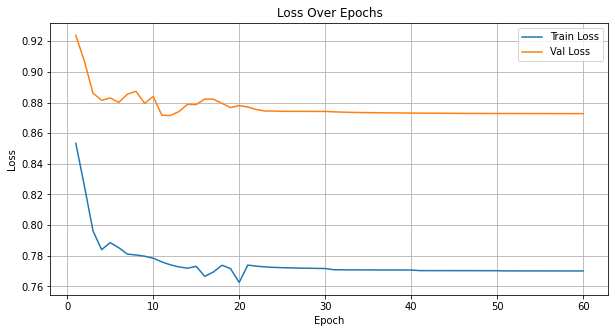

In [17]:
# 绘制训练和验证损失图
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


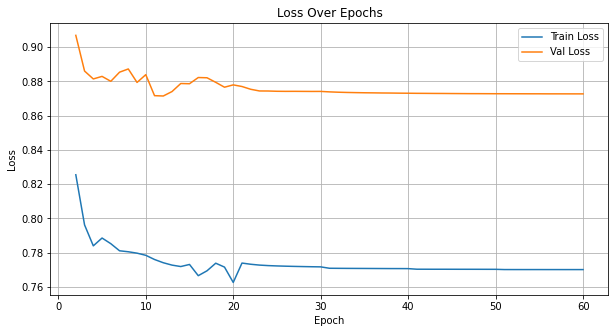

In [18]:
# 绘制训练和验证损失图
plt.figure(figsize=(10, 5))
plt.plot(range(2, num_epochs + 1), train_losses[1:], label='Train Loss')
plt.plot(range(2, num_epochs + 1), val_losses[1:], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


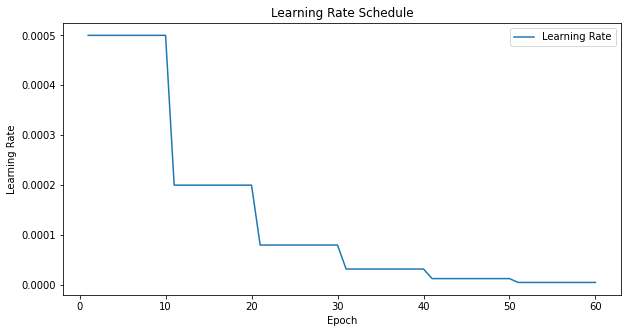

In [19]:
# 绘制学习率变化曲线
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), learning_rates, label='Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.legend()
plt.show()

In [20]:
# cov

In [21]:
# 现在已经训练好了模型，计算cov的值
cov = []
# 验证过程
model.eval()
total_val_loss = 0.0
with torch.no_grad():
    for val_features, val_returns in zip(test_feature, test_return):
        val_features = val_features.to(device)
        val_returns = val_returns.to(device)
        factors = model(val_features)  # 生成因子
        cov_sum = torch.zeros(stock_n, stock_n).to(device)

        # 计算每个 639x4 矩阵的协方差矩阵并累加
        for i in range(factors.size(0)):
            mat = factors[i]  # 取出第 i 个 639x4 的矩阵
            cov_matrix = torch.mm(mat, mat.t())  # 计算协方差矩阵 639x639
            cov_sum += cov_matrix.to(device)  # 累加协方差矩阵

        # 计算协方差矩阵的平均值
        cov_mean = cov_sum / factors.size(0)#这个就是我们想要的covariance矩阵
        cov.append(cov_mean)

In [22]:
new_cov_list = []
for i in range(len(cov)):
    new_cov_list.append(cov[i])
    if i != len(cov) - 1:
        new_cov_list.append((cov[i] + cov[i+1]) / 2)
    else:
        new_cov_list.append(cov[i])
len(new_cov_list)

518

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [24]:
# 计算组合的预期回报和风险
def portfolio_performance(weights, mean_returns, cov_matrix):
    # 确保 mean_returns 和 cov_matrix 是 NumPy 数组
    if isinstance(mean_returns, torch.Tensor):
        mean_returns = mean_returns.cpu().numpy()
    if isinstance(cov_matrix, torch.Tensor):
        cov_matrix = cov_matrix.cpu().numpy()
    
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return portfolio_return, portfolio_std_dev

# 计算夏普比率
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_return, p_std_dev = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_std_dev

# 约束条件和边界
def get_portfolio_optimization(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [25]:
import numpy as np
from tqdm import tqdm

# 假设这些变量已经在GPU上，并且需要移动到CPU上
test_feature = test_feature.cpu()
new_cov_list = [cov.cpu() for cov in new_cov_list]
test_return = test_return.cpu()

days = test_feature.shape[0] * test_feature[0].shape[0]
risk_free_rate = 0.03
portfolio_future_returns = np.zeros(days)
equal_value_returns = np.zeros(days)

# 初始化累计收益率
cumulative_portfolio_returns = np.zeros(days)
cumulative_equal_value_returns = np.zeros(days)
total_portfolio_return = 0
total_equal_value_return = 0

for day in tqdm(range(days), desc="Processing days"):
    # 提前计算索引，减少重复计算
    index1 = int(day / 2)
    index2 = day % 2
    
    # 获取当前的 mean returns
    now_feature = test_feature[index1][index2][0].cpu().numpy()
    now_mean_returns = np.mean(now_feature[:, [6, 8]], axis=1)
    
    # 获取协方差矩阵
    cov_matrix = new_cov_list[day].cpu().numpy()
    optimal_risky_portfolio = get_portfolio_optimization(now_mean_returns, cov_matrix, risk_free_rate)
    
    # 获取未来的 mean returns
    future_returns = test_return[index1][index2][0].cpu().numpy()
    future_mean_returns = future_returns[:, 0]
    
    # 计算投资组合收益率和等值收益率
    portfolio_return = np.dot(optimal_risky_portfolio.x, future_mean_returns)
    equal_value_return = np.mean(future_mean_returns)
    
    portfolio_future_returns[day] = portfolio_return
    equal_value_returns[day] = equal_value_return

    # 更新累计收益率
    total_portfolio_return = (total_portfolio_return + 1) * (1 + portfolio_return) - 1
    total_equal_value_return = (total_equal_value_return + 1) * (1 + equal_value_return) - 1
    
    cumulative_portfolio_returns[day] = total_portfolio_return
    cumulative_equal_value_returns[day] = total_equal_value_return

Processing days: 100%|██████████| 518/518 [3:27:58<00:00, 24.09s/it]  


In [26]:
# import numpy as np
# from tqdm import tqdm
# from concurrent.futures import ProcessPoolExecutor, as_completed

# days = test_feature.shape[0] * test_feature[0].shape[0]
# risk_free_rate = 0.03
# portfolio_future_returns = np.zeros(days)
# equal_value_returns = np.zeros(days)

# # 初始化累计收益率
# cumulative_portfolio_returns = np.zeros(days)
# cumulative_equal_value_returns = np.zeros(days)
# total_portfolio_return = 0
# total_equal_value_return = 0

# def process_day(day):
#     # 提前计算索引，减少重复计算
#     index1 = int(day / 2)
#     index2 = day % 2
    
#     # 获取当前的 mean returns
#     now_feature = test_feature[index1][index2][0].cpu().numpy()  # 移动到CPU
#     now_mean_returns = np.mean(now_feature[:, [6, 8]], axis=1)
    
#     # 获取协方差矩阵
#     cov_matrix = new_cov_list[day].cpu().numpy()  # 移动到CPU
#     optimal_risky_portfolio = get_portfolio_optimization(now_mean_returns, cov_matrix, risk_free_rate)
    
#     # 获取未来的 mean returns
#     future_returns = test_return[index1][index2][0].cpu().numpy()  # 移动到CPU
#     future_mean_returns = future_returns[:, 0]
    
#     # 计算投资组合收益率和等值收益率
#     portfolio_return = np.dot(optimal_risky_portfolio.x, future_mean_returns)
#     equal_value_return = np.mean(future_mean_returns)
    
#     return day, portfolio_return, equal_value_return

# with ProcessPoolExecutor() as executor:
#     futures = {executor.submit(process_day, day): day for day in range(days)}
#     for future in tqdm(as_completed(futures), total=days, desc="Processing days"):
#         day, portfolio_return, equal_value_return = future.result()
        
#         portfolio_future_returns[day] = portfolio_return
#         equal_value_returns[day] = equal_value_return

#         # 更新累计收益率
#         total_portfolio_return = (total_portfolio_return + 1) * (1 + portfolio_return) - 1
#         total_equal_value_return = (total_equal_value_return + 1) * (1 + equal_value_return) - 1
        
#         cumulative_portfolio_returns[day] = total_portfolio_return
#         cumulative_equal_value_returns[day] = total_equal_value_return

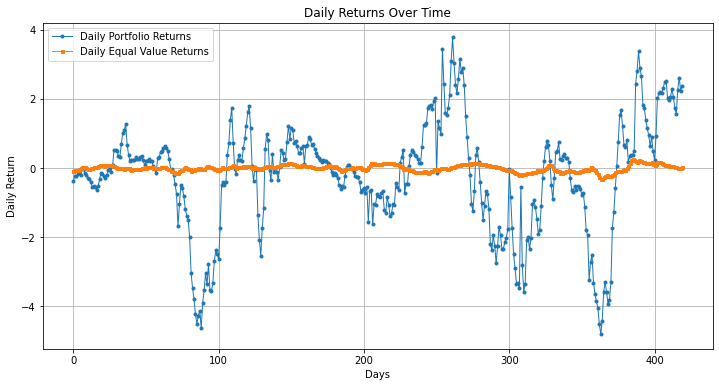

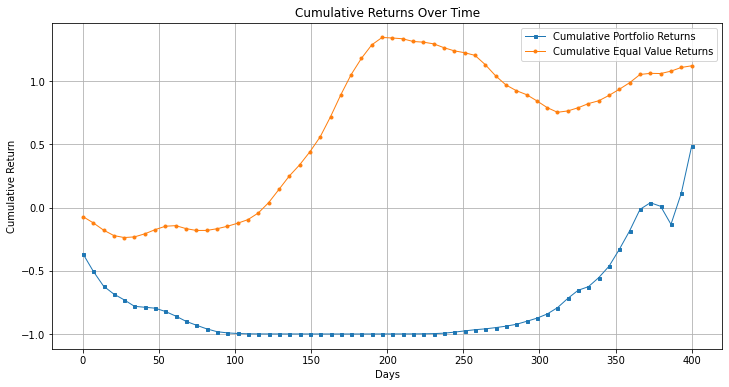

In [48]:
# 绘制每日收益率对比图
plt.figure(figsize=(12, 6))
plt.plot(portfolio_future_returns[:420], label='Daily Portfolio Returns', marker='o', markersize=3, linewidth=1)
plt.plot(equal_value_returns[:420], label='Daily Equal Value Returns', marker='s', markersize=3, linewidth=1)
plt.title('Daily Returns Over Time')
plt.xlabel('Days')
plt.ylabel('Daily Return')
plt.legend()
plt.grid(True)
plt.show()

# 绘制累计收益率对比图
plt.figure(figsize=(12, 6))
plt.plot(cumulative_portfolio_returns[:60], label='Cumulative Portfolio Returns', marker='s', markersize=3, linewidth=1)
plt.plot(cumulative_equal_value_returns[:60], label='Cumulative Equal Value Returns', marker='o', markersize=3, linewidth=1)
plt.title('Cumulative Returns Over Time')
plt.xlabel('Days')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.xticks(ticks=np.linspace(0, 59, num=9), labels=np.linspace(0, 400, num=9, dtype=int))
plt.show()